In [58]:
import stim
import numpy as np
import pymatching
import sinter
from typing import List
import matplotlib.pyplot as plt
import scipy.stats

In [59]:
data_qubit_coords={(2,0):1,(2,2):2,(2,4):3,(4,4):4,(0,6):5,(2,6):6,(4,6):7,(4,0):8,(6,0):9, (4,2):10, (6,2):11}
ancilla_qubit_coords={(1,4):12, (3,2):13, (3,6):14, (5,4):15, (5,0):16, (1,6):17, (2,3):18, (4,3):19, (3,0):20, (6,1):21, (1,4):22, (3,2):23, (3,6):24, (5,4):25, (5,0):26}
color_face_Z_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)}
color_face_X_stabilizer = {22: (2, 3, 5, 6), 23: (1, 2, 3, 4), 24: (3, 4, 6, 7)}
edge_X_stabilizer = {17: (5,6), 18: (2,3), 19: (4,10), 20: (1,8)}
surface_face_X_stabilizer = {24: (3, 4, 6, 7)}

In [60]:
import stim

# 回路の初期化
def initialize_circuit():
    return stim.Circuit()

# キュービットの座標とインデックスの定義
def define_qubit_coords():
    return {
        1: (2, 0), 2: (2, 2), 3: (2, 4), 4: (4, 4), 5: (0, 6),
        6: (2, 6), 7: (4, 6), 8: (4, 0), 9: (6, 0), 10: (4, 2), 11: (6, 2),
        12: (1, 4), 13: (3, 2), 14: (3, 6), 15: (5, 4), 16: (5, 0),
        17: (1, 6), 18: (2, 3), 19: (4, 3), 20: (3, 0), 21: (6, 1),
        22: (1, 4), 23: (3, 2), 24: (3, 6), 25: (5, 4), 26: (5, 0)
    }

# QUBIT_COORDS命令の追加
def append_qubit_coords(circuit, qubit_coords):
    for qubit, (x, y) in qubit_coords.items():
        circuit.append("QUBIT_COORDS", [qubit], [x, y])

# すべてのデータキュービットをリセット
def reset_data_qubits(circuit, data_qubits):
    for qubit in data_qubits:
        circuit.append("R", [qubit])

# すべてのアンシラキュービットをリセット
def reset_ancilla_qubits(circuit, ancilla_qubits):
    for qubit in ancilla_qubits:
        circuit.append("R", [qubit])

# シンドローム測定の追加
def append_syndrome_measurement(circuit, stabilizer, is_X_stabilizer=False, add_detector=True):
    # CNOTゲートの適用の前後にHゲートを追加
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
    
    # CNOTゲートの適用
    max_iterations = max(len(data_qubits) for data_qubits in stabilizer.values())
    for i in range(max_iterations):
        for ancilla, data_qubits in stabilizer.items():
            if i < len(data_qubits):
                data_qubit = data_qubits[i]
                if is_X_stabilizer:
                    circuit.append("CX", [ancilla, data_qubit])
                else:
                    circuit.append("CX", [data_qubit, ancilla])
        circuit.append("TICK")
    
    # CNOTゲートの後にHゲートを追加
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
    
    # MR命令を追加
    for ancilla in stabilizer.keys():
        circuit.append("MR", [ancilla])
    
    # DETECTORの追加
    if add_detector:
        for idx, ancilla in enumerate(stabilizer.keys()):
            circuit.append("DETECTOR", [stim.target_rec(-len(stabilizer) + idx)])

# メイン関数
if __name__ == "__main__":
    circuit = initialize_circuit()
    qubit_coords = define_qubit_coords()
    data_qubits = [qubit for qubit in qubit_coords.keys() if qubit <= 11]  # データキュービットのリストを作成
    ancilla_qubits = [qubit for qubit in qubit_coords.keys() if qubit > 11]  # アンシラキュービットのリストを作成

    color_face_Z_stabilizer = {
        12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)
    }
    color_face_X_stabilizer = {
        22: (2, 3, 5, 6), 23: (1, 2, 3, 4), 24: (3, 4, 6, 7)
    }
    edge_X_stabilizer = {
        17: (5, 6), 18: (2, 3), 19: (4, 10), 20: (1, 8)
    }
    surface_face_X_stabilizer = {
        24: (3, 4, 6, 7)
    }

    append_qubit_coords(circuit, qubit_coords)
    reset_data_qubits(circuit, data_qubits)
    reset_ancilla_qubits(circuit, ancilla_qubits)
    circuit.append("TICK")
    append_syndrome_measurement(circuit, color_face_Z_stabilizer)
    append_syndrome_measurement(circuit, color_face_X_stabilizer, is_X_stabilizer=True)

    # qubit 8, 9, 10, 11 を測定
    circuit.append("MR", [8, 9, 10, 11])
    append_syndrome_measurement(circuit, edge_X_stabilizer, is_X_stabilizer=True, add_detector=False)

    # surface_face_X_stabilizer の測定の直前に H を追加
    append_syndrome_measurement(circuit, surface_face_X_stabilizer, is_X_stabilizer=True)
    circuit.append("TICK")

    # qubit 12にedge stabilizerのアンシラ17, 18の測定値の積のdetectorを追加
    circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-4)], [12])

    # qubit 13にedge stabilizerのアンシラ18, 19, 20の測定値の積のdetectorを追加
    circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-3), stim.target_rec(-2)], [13])

    # 回路の表示
    print(circuit)


QUBIT_COORDS(2, 0) 1
QUBIT_COORDS(2, 2) 2
QUBIT_COORDS(2, 4) 3
QUBIT_COORDS(4, 4) 4
QUBIT_COORDS(0, 6) 5
QUBIT_COORDS(2, 6) 6
QUBIT_COORDS(4, 6) 7
QUBIT_COORDS(4, 0) 8
QUBIT_COORDS(6, 0) 9
QUBIT_COORDS(4, 2) 10
QUBIT_COORDS(6, 2) 11
QUBIT_COORDS(1, 4) 12
QUBIT_COORDS(3, 2) 13
QUBIT_COORDS(3, 6) 14
QUBIT_COORDS(5, 4) 15
QUBIT_COORDS(5, 0) 16
QUBIT_COORDS(1, 6) 17
QUBIT_COORDS(2, 3) 18
QUBIT_COORDS(4, 3) 19
QUBIT_COORDS(3, 0) 20
QUBIT_COORDS(6, 1) 21
QUBIT_COORDS(1, 4) 22
QUBIT_COORDS(3, 2) 23
QUBIT_COORDS(3, 6) 24
QUBIT_COORDS(5, 4) 25
QUBIT_COORDS(5, 0) 26
R 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
TICK
CX 2 12 1 13 3 14
TICK
CX 3 12 2 13 4 14
TICK
CX 5 12 3 13 6 14
TICK
CX 6 12 4 13 7 14
TICK
MR 12 13 14
DETECTOR rec[-3]
DETECTOR rec[-2]
DETECTOR rec[-1]
H 22 23 24
CX 22 2 23 1 24 3
TICK
CX 22 3 23 2 24 4
TICK
CX 22 5 23 3 24 6
TICK
CX 22 6 23 4 24 7
TICK
H 22 23 24
MR 22 23 24
DETECTOR rec[-3]
DETECTOR rec[-2]
DETECTOR rec[-1]
MR 8 9 10 11
H 17 18 19 20
CX

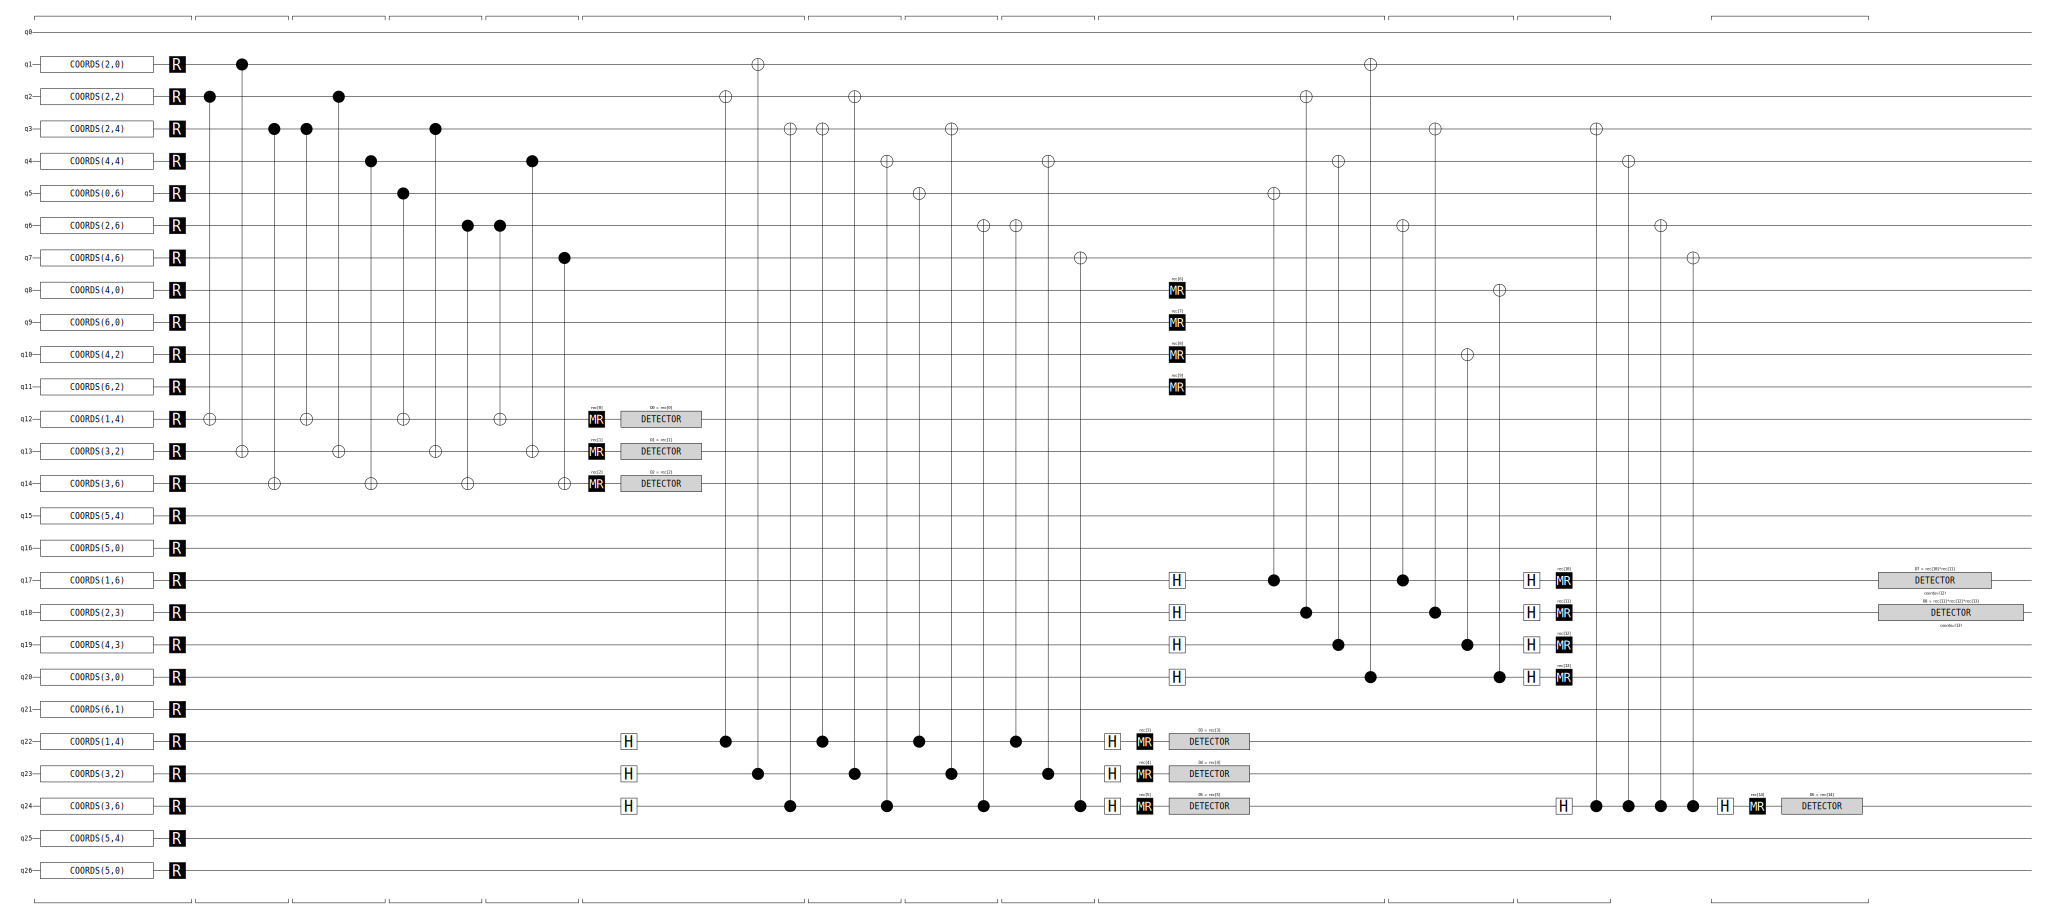

In [61]:
circuit.diagram("timeline-svg")

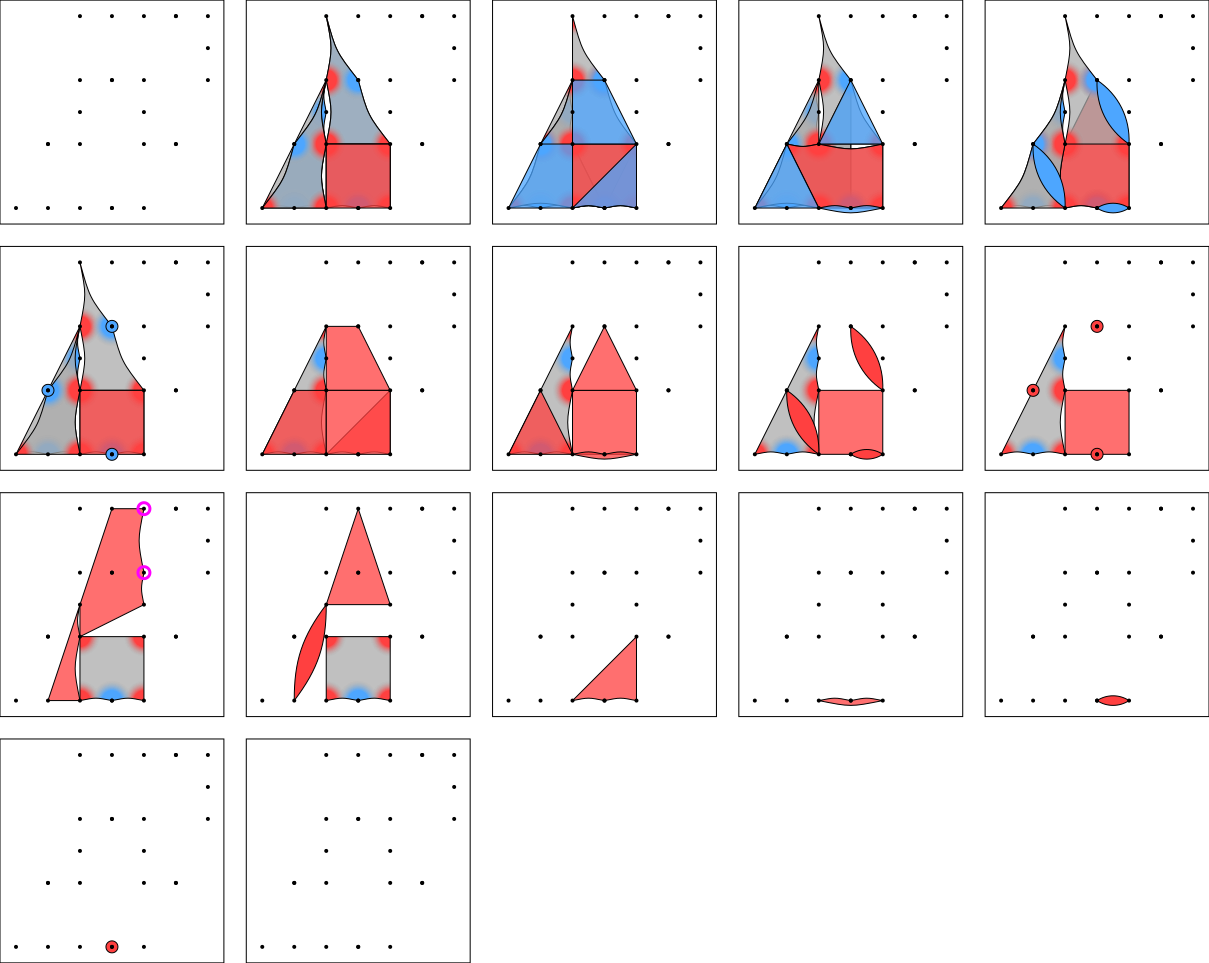

In [62]:
circuit.diagram("detslice-svg")

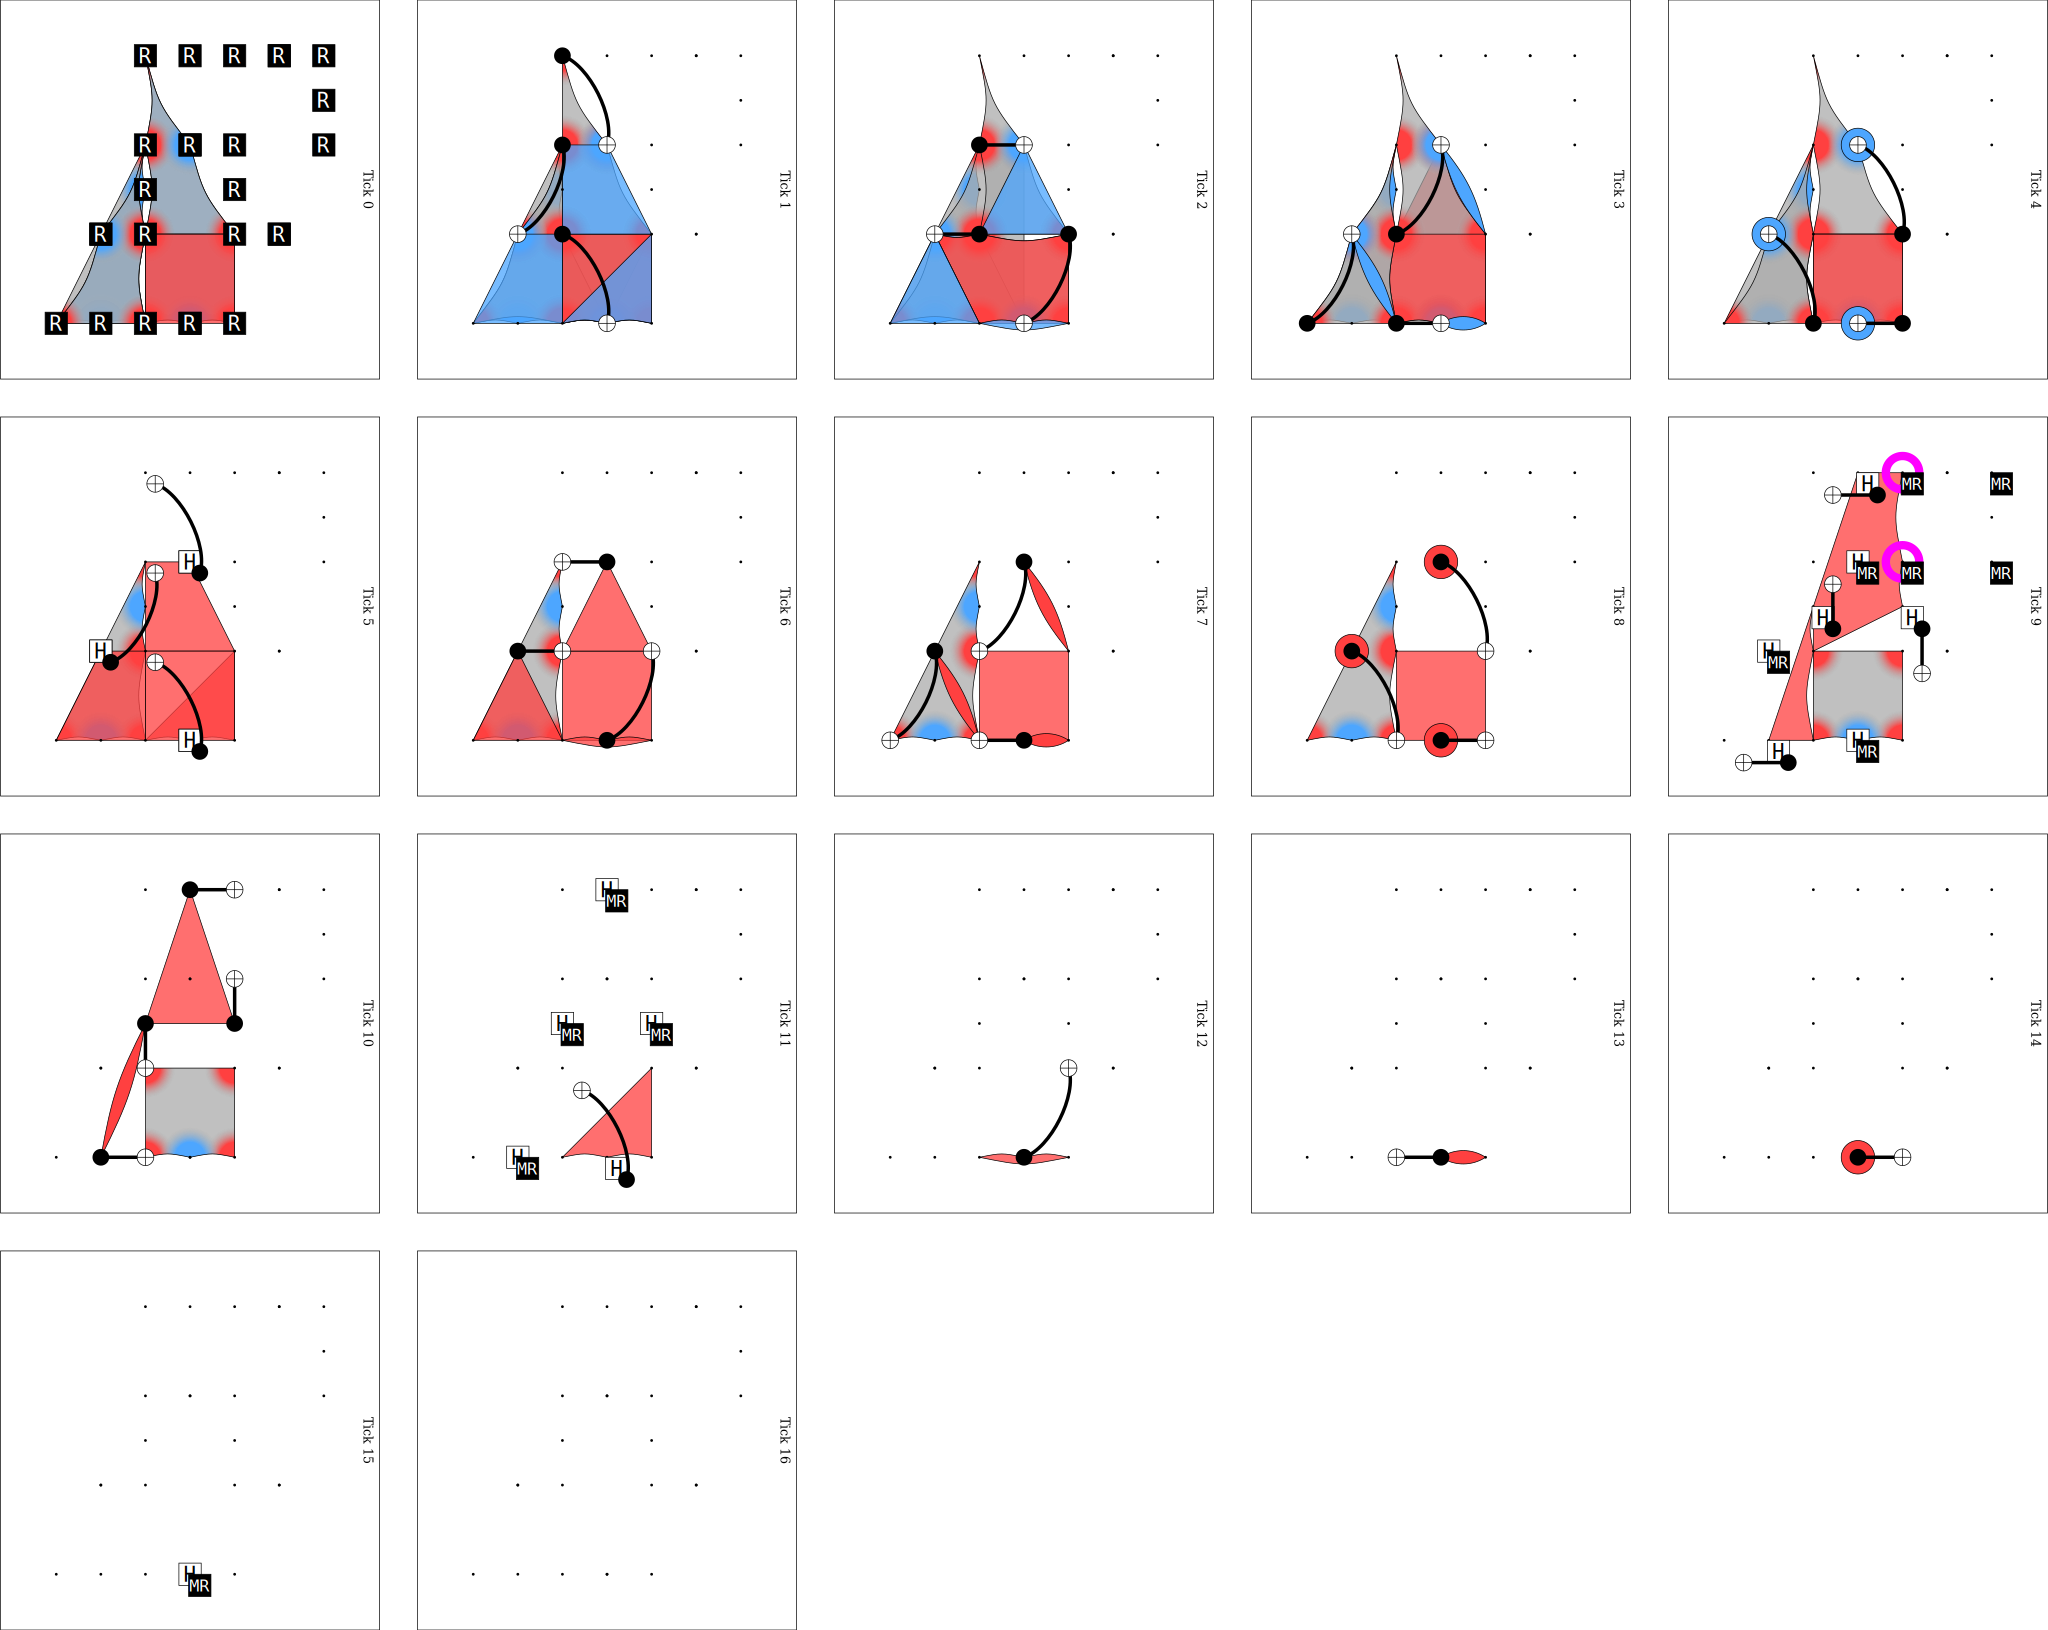

In [63]:
circuit.without_noise().diagram(
    "detslice-with-ops-svg", 
    tick=range(0, 100),
)